In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# need to add a shortcut of 'CSE_256_Project' folder in 'MyDrive'
data_path = '/content/drive/MyDrive/CSE_256_Project/data/'
df = pd.read_csv(data_path + '/sst-2_train.csv')
# df = pd.read_csv('tweets.csv')

df = df.sample(frac=1).reset_index(drop=True)

sst_texts = df.sentence.values
# texts = df.text.values
labels = df.label.values

Mounted at /content/drive


In [10]:
%pip install transformer_lens
%pip install circuitsvis
%pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import torch
from transformer_lens import HookedTransformer
from typing import Dict, Union, List
import gradio as gr
from transformer_lens.utils import to_numpy
from IPython.display import HTML

torch.set_grad_enabled(False)  # save memory
model = HookedTransformer.from_pretrained("gpt2-xl")
model.eval()
if torch.cuda.is_available():
    model.to('cuda')


def get_neuron_acts(text, layer, neuron_index):
    # Hacky way to get out state from a single hook - we have a single element list and edit that list within the hook.
    cache = {}

    def caching_hook(act, hook):
        cache["activation"] = act[0, :, neuron_index]

    model.run_with_hooks(
        text, fwd_hooks=[(f"blocks.{layer}.mlp.hook_post", caching_hook)]
    )
    return to_numpy(cache["activation"])

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [31]:
gpt2_text = 'Public Inc. announced the launch of Sit Kicker. Sit Kicker is a nationwide initiative focused on encouraging Canadians who work in office settings to reduce sedentary behaviour and "kick the sit" out of their work habits by shifting workplace culture towards more stand-friendly physical work environments. The Public Health Agency of Canada is providing'
gpt2_tokens = model.to_tokens(gpt2_text)

default_layer = 21
default_neuron_index = 2932
print(model.to_str_tokens(gpt2_text))
print(get_neuron_acts(gpt2_text, default_layer, default_neuron_index))

['<|endoftext|>', 'Public', ' Inc', '.', ' announced', ' the', ' launch', ' of', ' Sit', ' Kick', 'er', '.', ' Sit', ' Kick', 'er', ' is', ' a', ' nationwide', ' initiative', ' focused', ' on', ' encouraging', ' Canadians', ' who', ' work', ' in', ' office', ' settings', ' to', ' reduce', ' sed', 'entary', ' behaviour', ' and', ' "', 'kick', ' the', ' sit', '"', ' out', ' of', ' their', ' work', ' habits', ' by', ' shifting', ' workplace', ' culture', ' towards', ' more', ' stand', '-', 'friendly', ' physical', ' work', ' environments', '.', ' The', ' Public', ' Health', ' Agency', ' of', ' Canada', ' is', ' providing']
[ 3.0345567e-02 -1.2449749e-01  6.3414079e-01  1.1684608e+00
 -1.7001133e-01 -8.6407743e-02 -7.8891933e-02 -4.7523014e-02
 -1.2944321e-01 -1.2590133e-01 -7.2261885e-02 -1.6021019e-01
  9.0067488e-01 -1.6459474e-01 -4.6006512e-02 -5.9493408e-02
 -5.7881549e-02 -3.8879093e-02 -1.6462146e-01 -4.6243098e-02
 -2.6917210e-02 -2.9468775e-02  7.4035578e+00 -2.8852530e-02
 -3.68

In [41]:
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)


# gpt2_cache["pattern", 0, "attn"]
print(gpt2_cache['blocks.0.mlp.hook_post'].shape)
print(gpt2_cache['blocks.0.hook_mlp_out'].shape)

gpt2_cache

torch.Size([65, 6400])
torch.Size([65, 1600])


ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [ ]:
for text in sst_texts[:3]:
  gpt2_tokens = model.to_tokens(text)
  print(model.to_str_tokens(text))
  print(get_neuron_acts(text, default_layer, default_neuron_index))

['<|endoftext|>', 'certain', 'ly', ' does', ' n', "'t", ' feel', ' like', ' a', ' film', ' that', ' str', 'ays', ' past', ' the', ' two', ' and', ' a', ' half', ' mark', ' ']
[ 3.0345581e-02  3.5813808e-01 -1.4394453e-01 -1.0119832e-02
 -1.3342145e-01 -1.6926257e-01 -4.9427669e-02 -5.4240092e-03
 -4.6847645e-02 -3.8183954e-02 -2.3672257e-02 -6.3111046e-03
 -3.9928239e-03 -5.6120398e-06 -1.9023104e-02 -6.9419354e-02
 -7.7339076e-03 -9.0615125e-04 -6.3718535e-02 -5.7276517e-02
 -1.9380020e-02]
['<|endoftext|>', 'l', 'acking', ' in', ' ch', 'ills', ' ']
[ 0.03034557 -0.12395169 -0.16946748 -0.16794991 -0.07364967 -0.10491695
 -0.02868183]
['<|endoftext|>', 'story', ' is', ' almost', ' an', ' after', 'thought', ' ']
[ 3.0345598e-02  1.1076046e+00 -1.6990599e-01 -2.7449178e-06
 -5.5735335e-03 -1.3655555e-04 -1.4773444e-02 -9.6799927e-03]


In [ ]:
# This is some CSS (tells us what style )to give each token a thin gray border, to make it easy to see token separation
style_string = """<style> 
    span.token {
        border: 1px solid rgb(123, 123, 123)
        } 
    </style>"""


def calculate_color(val, max_val, min_val):
    # Hacky code that takes in a value val in range [min_val, max_val], normalizes it to [0, 1] and returns a color which interpolates between slightly off-white and red (0 = white, 1 = red)
    # We return a string of the form "rgb(240, 240, 240)" which is a color CSS knows
    normalized_val = (val - min_val) / max_val
    return f"rgb(240, {240*(1-normalized_val)}, {240*(1-normalized_val)})"


def basic_neuron_vis(text, layer, neuron_index, max_val=None, min_val=None):
    """
    text: The text to visualize
    layer: The layer index
    neuron_index: The neuron index
    max_val: The top end of our activation range, defaults to the maximum activation
    min_val: The top end of our activation range, defaults to the minimum activation

    Returns a string of HTML that displays the text with each token colored according to its activation

    Note: It's useful to be able to input a fixed max_val and min_val, because otherwise the colors will change as you edit the text, which is annoying.
    """
    if layer is None:
        return "Please select a Layer"
    if neuron_index is None:
        return "Please select a Neuron"
    acts = get_neuron_acts(text, layer, neuron_index)
    act_max = acts.max()
    act_min = acts.min()
    # Defaults to the max and min of the activations
    if max_val is None:
        max_val = act_max
    if min_val is None:
        min_val = act_min
    # We want to make a list of HTML strings to concatenate into our final HTML string
    # We first add the style to make each token element have a nice border
    htmls = [style_string]
    # We then add some text to tell us what layer and neuron we're looking at - we're just dealing with strings and can use f-strings as normal
    # h4 means "small heading"
    htmls.append(f"<h4>Layer: <b>{layer}</b>. Neuron Index: <b>{neuron_index}</b></h4>")
    # We then add a line telling us the limits of our range
    htmls.append(
        f"<h4>Max Range: <b>{max_val:.4f}</b>. Min Range: <b>{min_val:.4f}</b></h4>"
    )
    # If we added a custom range, print a line telling us the range of our activations too.
    if act_max != max_val or act_min != min_val:
        htmls.append(
            f"<h4>Custom Range Set. Max Act: <b>{act_max:.4f}</b>. Min Act: <b>{act_min:.4f}</b></h4>"
        )
    # Convert the text to a list of tokens
    str_tokens = model.to_str_tokens(text)
    for tok, act in zip(str_tokens, acts):
        # A span is an HTML element that lets us style a part of a string (and remains on the same line by default)
        # We set the background color of the span to be the color we calculated from the activation
        # We set the contents of the span to be the token
        htmls.append(
            f"<span class='token' style='background-color:{calculate_color(act, max_val, min_val)}' >{tok}</span>"
        )

    return "".join(htmls)

In [ ]:
# The function outputs a string of HTML
default_max_val = 4.0
default_min_val = 0.0

for text in sst_texts[:3]:
  gpt2_tokens = model.to_tokens(text)
  print(model.to_str_tokens(text))
  print(get_neuron_acts(text, default_layer, default_neuron_index))
  default_html_string = basic_neuron_vis(
      text,
      default_layer,
      default_neuron_index,
      max_val=default_max_val,
      min_val=default_min_val,
  )

  # IPython lets us display HTML
  print("Displayed HTML")
  display(HTML(default_html_string))
  print()

# # We can also print the string directly
# print("HTML String - it's just raw HTML code!")
# print(default_html_string)

['<|endoftext|>', 'certain', 'ly', ' does', ' n', "'t", ' feel', ' like', ' a', ' film', ' that', ' str', 'ays', ' past', ' the', ' two', ' and', ' a', ' half', ' mark', ' ']
[ 3.0345581e-02  3.5813808e-01 -1.4394453e-01 -1.0119832e-02
 -1.3342145e-01 -1.6926257e-01 -4.9427669e-02 -5.4240092e-03
 -4.6847645e-02 -3.8183954e-02 -2.3672257e-02 -6.3111046e-03
 -3.9928239e-03 -5.6120398e-06 -1.9023104e-02 -6.9419354e-02
 -7.7339076e-03 -9.0615125e-04 -6.3718535e-02 -5.7276517e-02
 -1.9380020e-02]
Displayed HTML



['<|endoftext|>', 'l', 'acking', ' in', ' ch', 'ills', ' ']
[ 0.03034557 -0.12395169 -0.16946748 -0.16794991 -0.07364967 -0.10491695
 -0.02868183]
Displayed HTML



['<|endoftext|>', 'story', ' is', ' almost', ' an', ' after', 'thought', ' ']
[ 3.0345598e-02  1.1076046e+00 -1.6990599e-01 -2.7449178e-06
 -5.5735335e-03 -1.3655555e-04 -1.4773444e-02 -9.6799927e-03]
Displayed HTML


In [ ]:
from einops import rearrange

def get_all_mlp_neuron_acts(text):
    # Hacky way to get out state from a single hook - we have a single element list and edit that list within the hook.
    cache = {}

    n_layers = model.cfg.n_layers
    d_mlp = model.cfg.d_mlp
    n_positions = len(model.to_str_tokens(text))

    def caching_hook(act, hook):
        cache["activation"] = act[0, :, :]

    activation_shape = (n_layers, n_positions, d_mlp)
    activations = torch.zeros(activation_shape, device="cuda", dtype=torch.float32)

    for layer in range(n_layers):
        model.run_with_hooks(
            text, fwd_hooks = [
                (f"blocks.{layer}.mlp.hook_post", caching_hook)
            ]
        )
        activations[layer, :, :] = cache["activation"]

    # n_layers (48) x n_neurons (6400) x n_positions (length of text token)
    activations = rearrange(activations, 'l p d -> l d p')

    return to_numpy(activations)

In [12]:
from einops import rearrange

def get_all_mlp_neuron_acts(text):
  gpt2_tokens = model.to_tokens(text)
  gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

  n_layers = model.cfg.n_layers
  d_mlp = model.cfg.d_mlp
  n_positions = len(model.to_str_tokens(text))
  # print(n_positions, text)

  activation_shape = (n_layers, n_positions, d_mlp)
  activations = torch.zeros(activation_shape, device="cuda", dtype=torch.float32)

  for layer in range(n_layers):
    # print(gpt2_cache[f"blocks.{layer}.mlp.hook_post"].shape)
    activations[layer, :, :] = gpt2_cache[f"blocks.{layer}.mlp.hook_post"]

  # n_layers (48) x n_neurons (6400) x n_positions (length of text token)
  activations = rearrange(activations, 'l p d -> l d p')
  
  return to_numpy(activations)

In [13]:
for text in sst_texts[:3]:
  all_mlp_activations = get_all_mlp_neuron_acts(text)
  print(all_mlp_activations.shape)

(48, 6400, 10)
(48, 6400, 6)
(48, 6400, 31)


In [14]:
import numpy as np
from tqdm import tqdm

sample_size = 500

act_list = []
for text in tqdm(sst_texts[:sample_size]):
  all_mlp_activations = get_all_mlp_neuron_acts(text)
  act_list.append(all_mlp_activations)

# print(act_list)
import pickle
with open(data_path + "/sst_acts", 'wb') as f:
  pickle.dump(act_list, f)


100%|██████████| 500/500 [01:24<00:00,  5.93it/s]


In [2]:
import pickle
with open(data_path + "/sst_acts", 'rb') as f:
    act_list = pickle.load(f)

In [4]:
import numpy as np

max_act_neurons = []
for act in act_list:
  
  max_act_neuron = np.unravel_index(np.argmax(act, axis=None), act.shape)
  max_act_neurons.append(max_act_neuron)
  print('max activation neuron: ', max_act_neuron)

max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
max activation neuron:  (8, 1424, 0)
m

In [ ]:
import matplotlib.pyplot as plt

act_flatten_list = []
for act in act_list:
  act_flatten_list.append(np.ndarray.flatten(act))
act_flatten_list = np.concatenate(act_flatten_list, axis=-1)
plt.hist(act_flatten_list, bins=100)
plt.show()
print(act_flatten_list.max())
print(act_flatten_list.min())

(500, 48, 6400)
15.739251
average over 500 sentence:  (48, 6400)
max activation neuron:  (8, 1424)


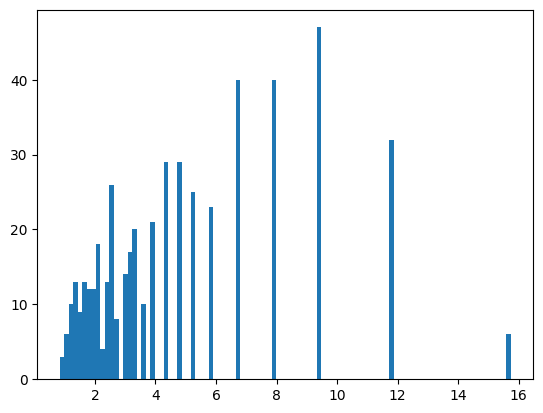

In [11]:
import matplotlib.pyplot as plt

sample_size = 500
act_avg_tokens = []
for act in act_list:
  act_avg_tokens.append(np.mean(act, axis=-1))
act_avg_tokens = np.array(act_avg_tokens)
print(act_avg_tokens.shape)
print(act_avg_tokens.max())

# # normalize the activations for each neuron
# # act_avg_tokens = (act_avg_tokens - act_avg_tokens.mean(axis=0)) / act_avg_tokens.std(axis=0)
# act_avg_tokens = (act_avg_tokens - act_avg_tokens.min(axis=0)) / (act_avg_tokens.max(axis=0) - act_avg_tokens.min(axis=0))
# print(act_avg_tokens.mean(axis=0).shape)
# print(act_avg_tokens.max())

act_avg_sentence = act_avg_tokens.mean(axis=0)
print('average over {} sentence: '.format(sample_size), act_avg_sentence.shape)
max_act_neuron = np.unravel_index(np.argmax(act_avg_sentence, axis=None), act_avg_sentence.shape)
print('max activation neuron: ', max_act_neuron)

plt.hist(act_avg_tokens[:, max_act_neuron[0], max_act_neuron[1]], bins=100)
plt.show()

max activation neuron:  (8, 1424)


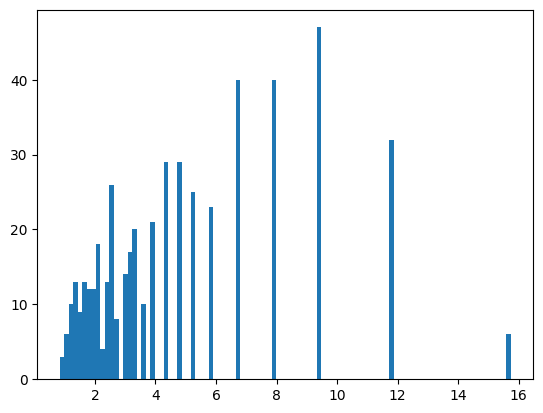

In [12]:
label = labels[:sample_size]
act_avg_tokens_pos = []
for i, act in enumerate(act_list):
  if label[i] == 1:
    act_avg_tokens_pos.append(np.mean(act, axis=-1))
act_avg_tokens_pos = np.array(act_avg_tokens_pos)

# # normalize the activations for each neuron
# act_avg_tokens_pos = (act_avg_tokens_pos - act_avg_tokens_pos.mean(axis=0)) / act_avg_tokens_pos.std(axis=0)

act_avg_sentence = act_avg_tokens_pos.mean(axis=0)
max_act_neuron = np.unravel_index(np.argmax(act_avg_sentence, axis=None), act_avg_sentence.shape)
print('max activation neuron: ', max_act_neuron)

plt.hist(act_avg_tokens[:, max_act_neuron[0], max_act_neuron[1]], bins=100)
plt.show()

max activation neuron:  (8, 1424)


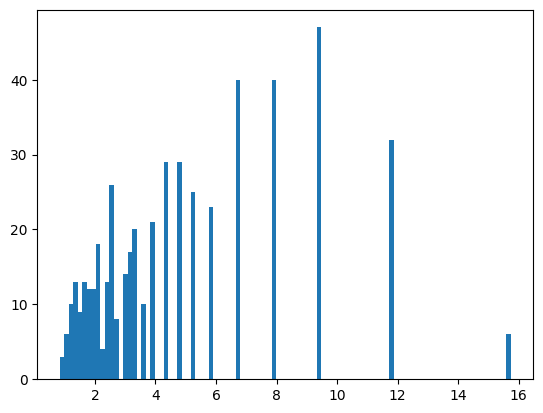

In [13]:
act_avg_tokens_neg = []
for i, act in enumerate(act_list):
  if label[i] == 0:
    act_avg_tokens_neg.append(np.mean(act, axis=-1))
act_avg_tokens_neg = np.array(act_avg_tokens_neg)

# # normalize the activations for each neuron
# act_avg_tokens_neg = (act_avg_tokens_neg - act_avg_tokens_neg.mean(axis=0)) / act_avg_tokens_neg.std(axis=0)


act_avg_sentence = act_avg_tokens_neg.mean(axis=0)
max_act_neuron = np.unravel_index(np.argmax(act_avg_sentence, axis=None), act_avg_sentence.shape)
print('max activation neuron: ', max_act_neuron)

plt.hist(act_avg_tokens[:, max_act_neuron[0], max_act_neuron[1]], bins=100)
plt.show()

max activation neuron:  (40, 1921)


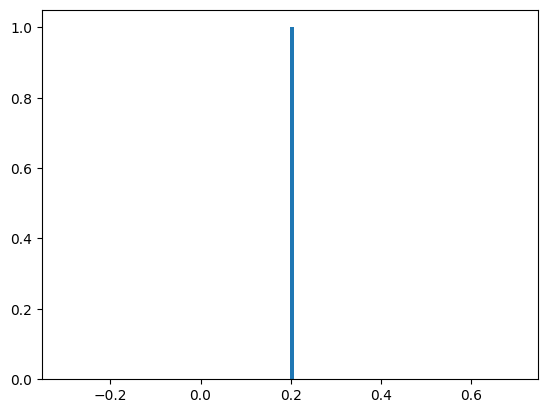

In [14]:
act_avg_sentence_diff = act_avg_tokens_pos.mean(axis=0) - act_avg_tokens_neg.mean(axis=0)
max_act_neuron = np.unravel_index(np.argmax(act_avg_sentence_diff, axis=None), act_avg_sentence_diff.shape)
print('max activation neuron: ', max_act_neuron)

plt.hist(act_avg_sentence_diff[max_act_neuron[0], max_act_neuron[1]], bins=100)
plt.show()